### Code to extract information from UW hackweek surveys collected on Qualtrics software

We generate a standard report from Qualtrics that is fine for visualizing responses for most of the questions. Here we have scripts to handle the questions that are not rendered well in that report. For example, we want to assess changes in people's learning from before to after the event.

Update 20221228 to create a generic version

## Export the data from Qualtrics

https://washington.co1.qualtrics.com/

First you'll need to export the Qualtrics results as a csv file. It's not that intuitive...

Go to the "Data and Analysis" tab, then choose "Export Data" in the "Export and Import" menu on the right: 

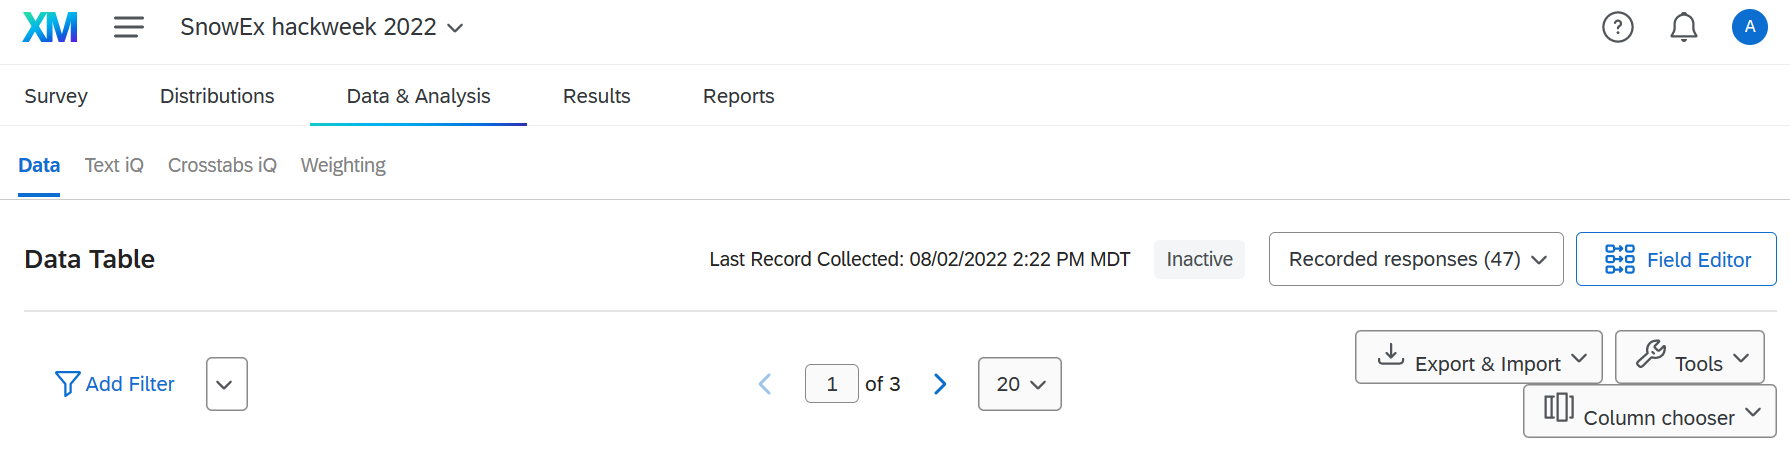

In [38]:
## Uses the "hackweek-admin" conda env

import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import folium
from folium.plugins import MarkerCluster

from QualtricsAPI.Survey import Responses, Credentials

import numpy as np
import matplotlib.pyplot as plt



In [27]:
c = Credentials()
c.qualtrics_api_credentials(token=os.environ["QUALTRICS_API_TOKEN"],
                            data_center='iad1',
                            directory_id='POOL_2y7wibMIA6ORiq4')

In [28]:
#Create an instance
r = Responses()

#Call the method
df = r.get_survey_responses(survey='SV_4GjwMl2RgEpeIoC')
df.drop([0,1], inplace = True)


In [29]:
questions = r.get_survey_questions(survey='SV_4GjwMl2RgEpeIoC')

In [30]:
df2 = df[["Q4", "Q5", "Q8", "Q12", "Q33_1", "Q33_2", "Q35", "Q16", "Q19", "Q20", "Q36", "Q37", "Q34", "LocationLatitude", "LocationLongitude"]]

# data cleaning and reclassifying

df2 = df2[~df2["Q16"].isna()]

lookup_table = {'1' : "Grad Student",
                '2': "Postdoc",
                '3': "Faculty",
                '4': "Research Staff",
                '5' : "Data/Software Engineer",
                '6' : "Other"
                }
df2["Q12"] = df2["Q12"].replace(lookup_table)

lookup_table = {'1' : "Virtual"}
df2["Q33_1"] = df2["Q33_1"].replace(lookup_table)

lookup_table = {'1' : "In Person"}
df2["Q33_2"] = df2["Q33_2"].replace(lookup_table)


df2.replace(np.nan,'missing',inplace = True)
df2 = df2.astype({"LocationLongitude":'float', "LocationLatitude" : 'float'})
df2.to_csv('temp.csv')
df2.to_excel('temp.xlsx', merge_cells=False)

In [31]:
geometry = [Point(lon, lat) for lon, lat in zip(df2["LocationLongitude"], df2["LocationLatitude"])]
gdf = gpd.GeoDataFrame(df2, geometry=geometry, crs="EPSG:4326")

<Figure size 7200x3600 with 0 Axes>

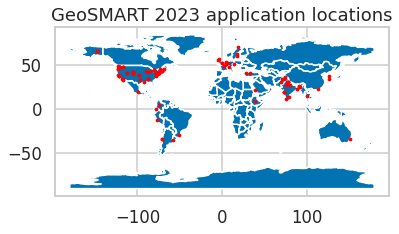

In [39]:
# Create a base world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


# Plot the world map
world.plot()

# Plot the GeoDataFrame on top of the world map
gdf.plot(marker='o', color='red', markersize=5, ax=plt.gca())

# Show the map
plt.title("GeoSMART 2023 application locations")
plt.show()




In [40]:
m = folium.Map(location=[35,-100], zoom_start=3)

# Create a MarkerCluster layer to group the markers
marker_cluster = MarkerCluster().add_to(m)

# Add markers for each city
for lat, lon in zip(df2["LocationLatitude"], df2["LocationLongitude"]):
    folium.Marker([lat, lon]).add_to(marker_cluster)

m

In [35]:
# number of people requesting travel support
df["Q36"].value_counts()

1    32
2    24
Name: Q36, dtype: int64